## Purpose of this notebook

Explain when and why you may need to resort to OCR to get textual data -- and when you may not need to go that far.

Also, we give an example of one package to do OCR with.

----

For context: There are requirements that varied government data be available in a machine-readable form, where possible.
While sometimes that means a near-data form, this is a gliding scale - it might also be an office-document form, PDF, or some combination.

The structured data is generally our preference to work with - but some things are only available as PDF.

Now, PDFs are only really meant to draw a document in a precisely controlled way.
Yet in practive, when a PDF is generated from text (from structured data, via browser forms, or office documents),
it will both contain instructions of how to draw that - and be annotated with the text it came from,
which we can read out.

Sometimes, however, PDF documents do not contain that. This particularly happens when they contain scanned images of text.

We care to turn that back into text we can feed to our text analysis methods.

----

Keep in mind that there are varied products and services out there that are intended as a
"put document-like things here, we make it easy to search", e.g. document managers 
such as [documentcloud](https://www.documentcloud.org/app) (TODO: list more).
When these apply to your projects they may be much lower-worry _and_ may scale better.

Some are meant for publication (so not necessarily an option when your data is not public),
others not so much (e.g. aimed at journalists who want to wade through a mass of documents sent to them).

Few give you a lot of control over results quality, though, so the below is an example of doing it yourself,
and there is a more complex example linked below (right after an example of why you might want that).

----

This is provided in part as expectation management about 
  ease of use and output quality of modern OCR.

Keep in mind that OCR is not considered core feature, 
  is currently a thin wrapper around something else,
  and is likely to change in the future (e.g. tesseract may be more future-compatible than easyocr).
  Also consider that services like google vision are better-quality, but paid-for and may not be GDPR-compatible, etc. A summary of such details may be useful.



In [1]:
import wetsuite.helpers.net
import wetsuite.helpers.format
import wetsuite.datacollect.pdf
import wetsuite.extras.ocr

### Notice we may need this

It is the responsibility of the PDF creator to have a PDF contain actual text if possible.
(Also to put that text in a sensible order, a separate problem we're not yet discussing here)

In [ ]:
# fetch a cherry-picked example
pdfbytes = wetsuite.helpers.net.download('https://open.overheid.nl/documenten/ronl-5439f4bf9849a53e634389ebbb5e4f5740c4f84f/pdf')

In [5]:
# extract the text already contained in the PDF 
chars_per_page, num_pages_with_text, num_pages = wetsuite.datacollect.pdf.count_pages_with_text(pdfbytes, char_threshold=150)

In [7]:
print(f'{num_pages_with_text} out of {num_pages} pages contain reasonable amount of text\n  characters per page: {chars_per_page}')

7 out of 20 pages contain reasonable amount of text
  characters per page: [1477, 2699, 707, 602, 2365, 2582, 399, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


...which very much looks like a PDF composed of a response letter as text,
plus the actual requested documents as image (scanned documents).

### PDF to image, image to text

OCR takes images as input, so now we want the PDF as images.

We _could_ skip the pages we alreay have text for and save some processing time,
but it's less _code_ (though more analysis time) to see what it makes of the pages we do have text for. 

(It's also potentially a good double-check of the OCR to see that the PDF's text matches what OCR extracts)

In [5]:
# should take a few seconds.
page_images = list( wetsuite.datacollect.pdf.pages_as_images(pdfbytes, dpi=200, antialiasing=True) )
# Note: In this fragment we do all at once instead of using a generator, which is a bad idea in general because for, say, a 300-page document that's a lot of RAM

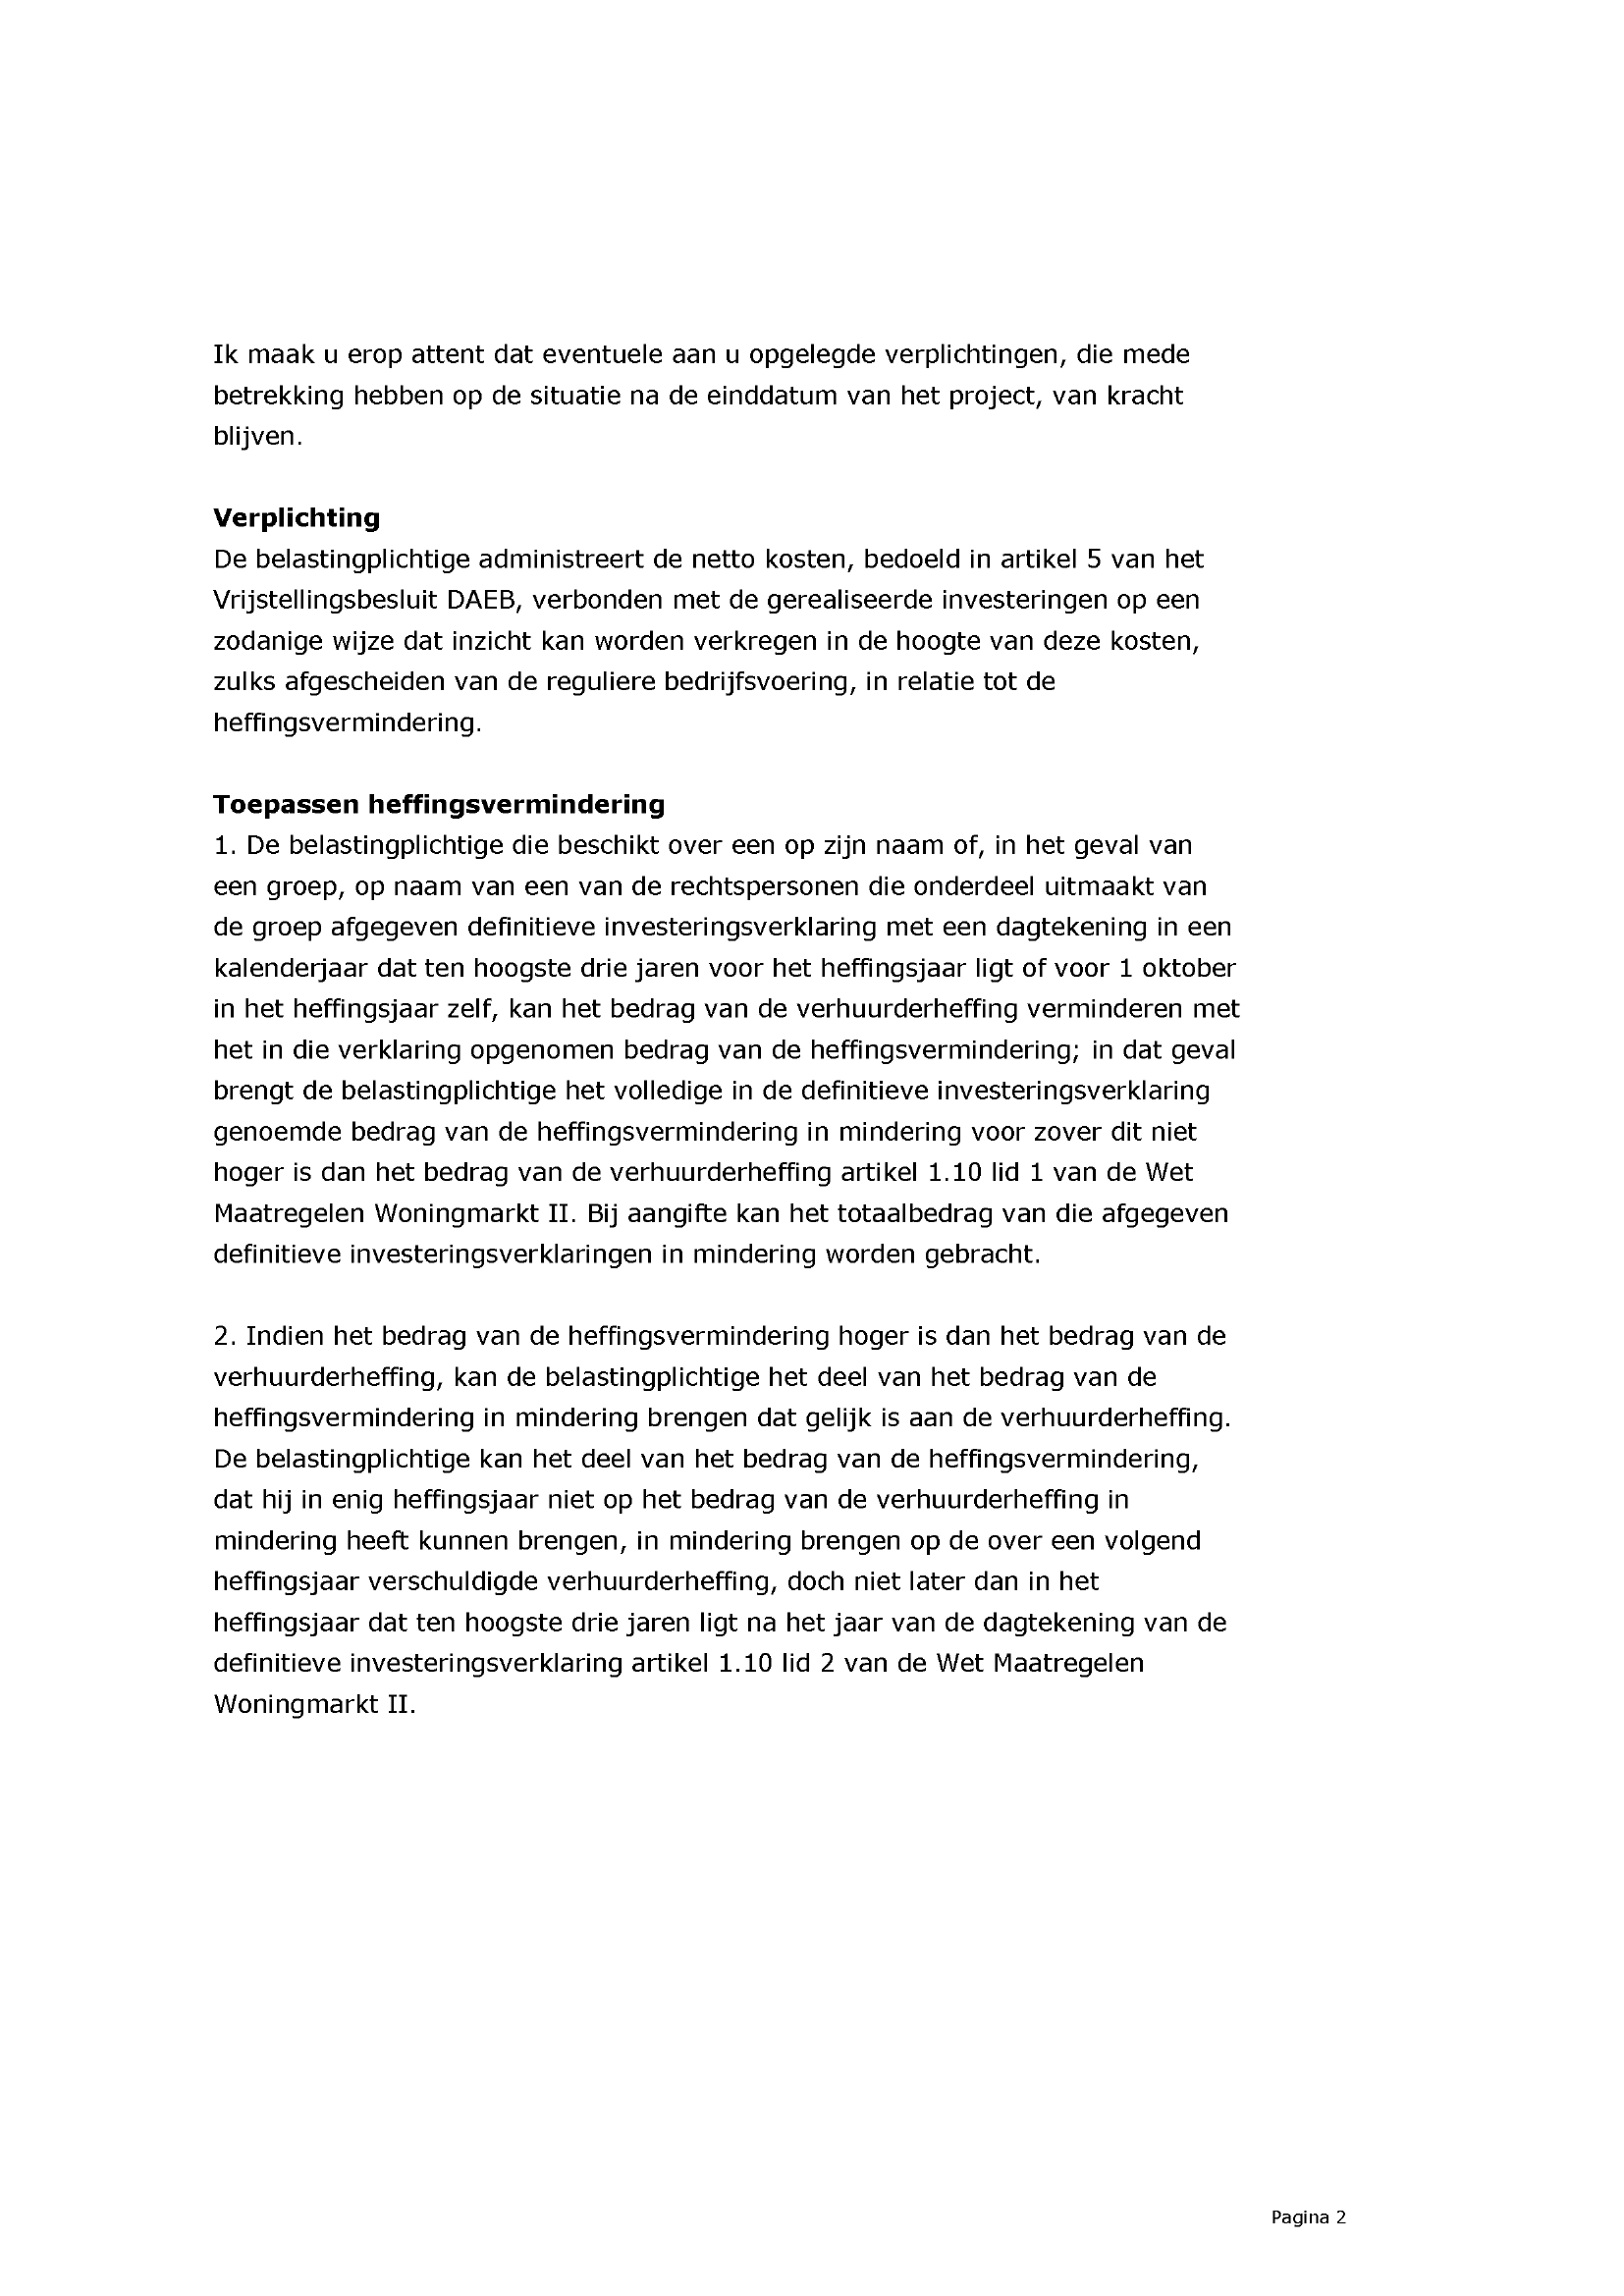

In [7]:
# show us the second page we didn't get text for
#   (notebooks treat PIL images by showing them. In practice you might .save() them instead)
chosen_image = page_images[8]
chosen_image   

In [ ]:
page_ocr_results = wetsuite.extras.ocr.easyocr( chosen_image, use_gpu=True ) 
# if GPU fails, use False,  though it'll be slower.
#  Even on GPU it'll take a minute, and despite that _some_ of that is initial loading,
#     the same on CPU will probably take a few times as long.

In [15]:
# what did that produce?
page_ocr_results

[([(213, 343), (1217, 343), (1217, 383), (213, 383)],
  'Ik maak u erop attent dat eventuele aan u opgelegde verplichtingen, die mede',
  0.7733649478286609),
 ([(214, 386), (1211, 386), (1211, 423), (214, 423)],
  'betrekking hebben op de situatie na de einddatum van het project, van kracht',
  0.9009250426350395),
 ([(216, 430), (308, 430), (308, 462), (216, 462)],
  'blijven.',
  0.6428019007528218),
 ([(215, 511), (393, 511), (393, 549), (215, 549)],
  'Verplichting',
  0.7938799971147714),
 ([(215, 551), (1233, 551), (1233, 591), (215, 591)],
  'De belastingplichtige administreert de netto kosten, bedoeld in artikel 5 van het',
  0.7423204926955493),
 ([(213, 592), (1225, 592), (1225, 632), (213, 632)],
  'Vrijstellingsbesluit DAEB, verbonden met de gerealiseerde investeringen op een',
  0.801965299925563),
 ([(212, 633), (1227, 633), (1227, 674), (212, 674)],
  'zodanige wijze dat inzicht kan worden verkregen in de hoogte van deze kosten,',
  0.7243509398531254),
 ([(213, 676), (

That's OCR results in relatively raw form, namely fragments of:
- the bounds of the box that contains this fragment of text
- the text detected inside that box
- how certain the underlying code was about the detection of this text

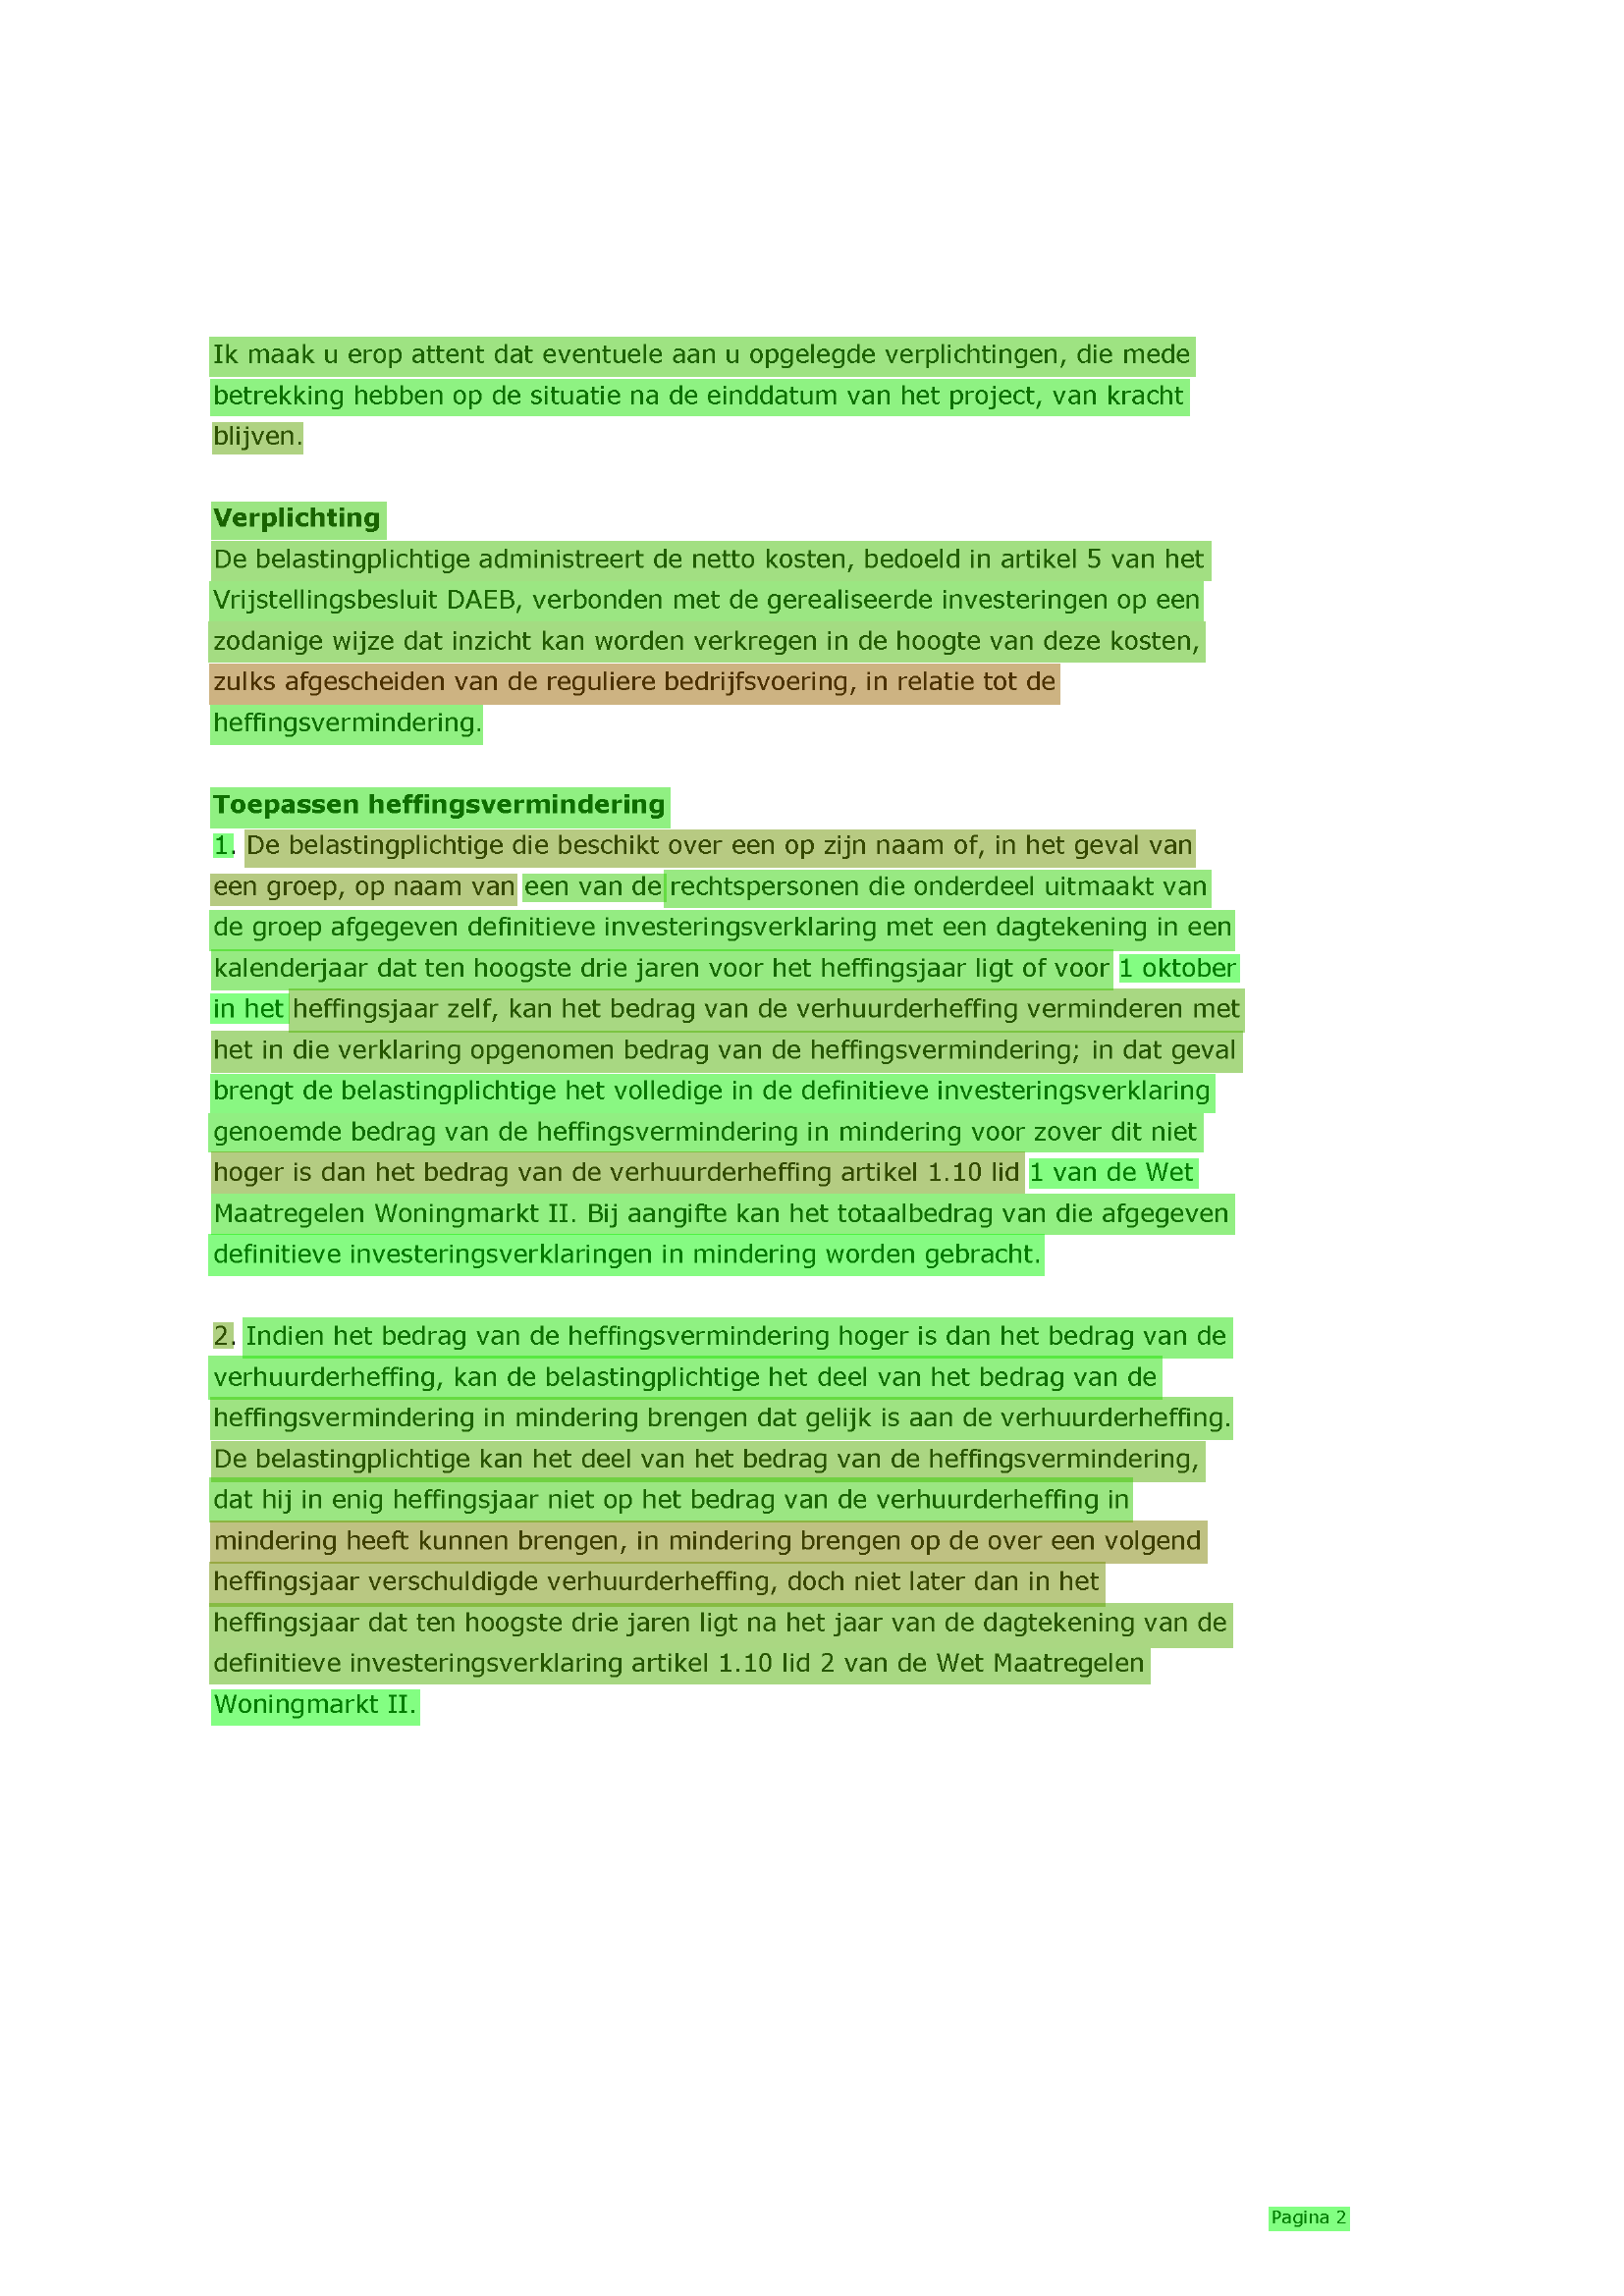

In [16]:
# As a double-check, we can draw those bounding boxes on the original image,
#   with color indicating that mentioned certainty
wetsuite.extras.ocr.easyocr_draw_eval( chosen_image, page_ocr_results ) 

In [17]:
# If you only really care about the words on the page (e.g. for bag-of-words methods),
# then you can get away with just taking out the text, e.g.
page_text = '\n'.join( list( text    for bbox, text, cert in page_ocr_results) )
print( page_text )

Ik maak u erop attent dat eventuele aan u opgelegde verplichtingen, die mede
betrekking hebben op de situatie na de einddatum van het project, van kracht
blijven.
Verplichting
De belastingplichtige administreert de netto kosten, bedoeld in artikel 5 van het
Vrijstellingsbesluit DAEB, verbonden met de gerealiseerde investeringen op een
zodanige wijze dat inzicht kan worden verkregen in de hoogte van deze kosten,
zulks afgescheiden van de reguliere bedrijfsvoering, in relatie tot de
heffingsvermindering.
Toepassen heffingsvermindering
1
De belastingplichtige die beschikt over een op zijn naam of, in het geval van
een groep, op naam van
een van de
rechtspersonen die onderdeel uitmaakt van
de groep afgegeven definitieve investeringsverklaring met een dagtekening in een
kalenderjaar dat ten hoogste drie jaren voor het heffingsjaar ligt of voor
1 oktober
in het
heffingsjaar zelf; kan het bedrag van de verhuurderheffing verminderen met
het in die verklaring opgenomen bedrag van de heffingsver

As you can see, it may fragment things acually on a single line,
it doesn't know how to separate paragraps,
and it includes words that we would say are obviously header/footer rather than the body
(which can be a feature, but for large repeated headers is also messy)

Turning this into well-flowing text takes a lot more care,
will always be a slightly creative process, 
and can be made to work better within document sets that have a consistent structure.

If you care to get into that, check out [datacollect_kansspelautoriteit.ipynb](datacollect_kansspelautoriteit.ipynb), though note it cares less about readability of the code and more about the data it produces.



### Quick and dirty variants

If you only care about the words that are in there, 
and less about nice interpretation,
then you can hand it a file and hope for the best.

In [38]:
import wetsuite.extras.pdf_text

out = wetsuite.extras.pdf_text.pdf_text_ocr( pdfbytes )
# expect this to take a minute even for smaller documents.

# there is an analogous
# wetsuite.extras.pdf2txt.pdf2txt_embedded( pdfbytes )
# and while much faster, it won't tell you that most pages are empty.

# More examples

== kst-31700-VIII-77-b1.pdf ==
raad voor cultuur
RJ
Schimmelpennincklaan 3
raad voor cultuur
postbus
raad voor cultuur
2506 AE Den
telefoon +31(0)70310 66 86
fax +31(0)70 3614727
e-mail
cultuur@cultuurnl
www.cultuur,nl
De minister van
'Onderwijs; Cultuur en Wetenschap
de beer d. RHA Plasterk
Postbus 16375
2500 BJ Den
datum: 3 december 2008
uw kenmerk; WJZ-71524(8235)
uw brief van;
povember 2008
ons
kenmerk: bcma-2008,05106/2
onderwerp: Advies Beleidsregel aanwizing beschermde monumentea 2009
Geachte heer Plasterk,
In uw brief van
novcmber 2008 stelt u de Raad
voor Cultuur in de gelegenheid advies uit
over bet
Ontwerp-Beleidsrcgel aanwijzing beschemde
(bierna te noemen: de
beleidsregel) 
monumenten 2009
De
'beleidsregel ,
aan het beleid dat u voorstaat
van monumenten als bescherd
met
betrekking tot aanwijzing
1988. De
monument op grond van artikel 3 van de Monumentcnweg
beleidsrcgel biedt mcer ruimte voor aanwijzing van
monument dan de huidige beleidsregel
monumenten als beschermd
laats

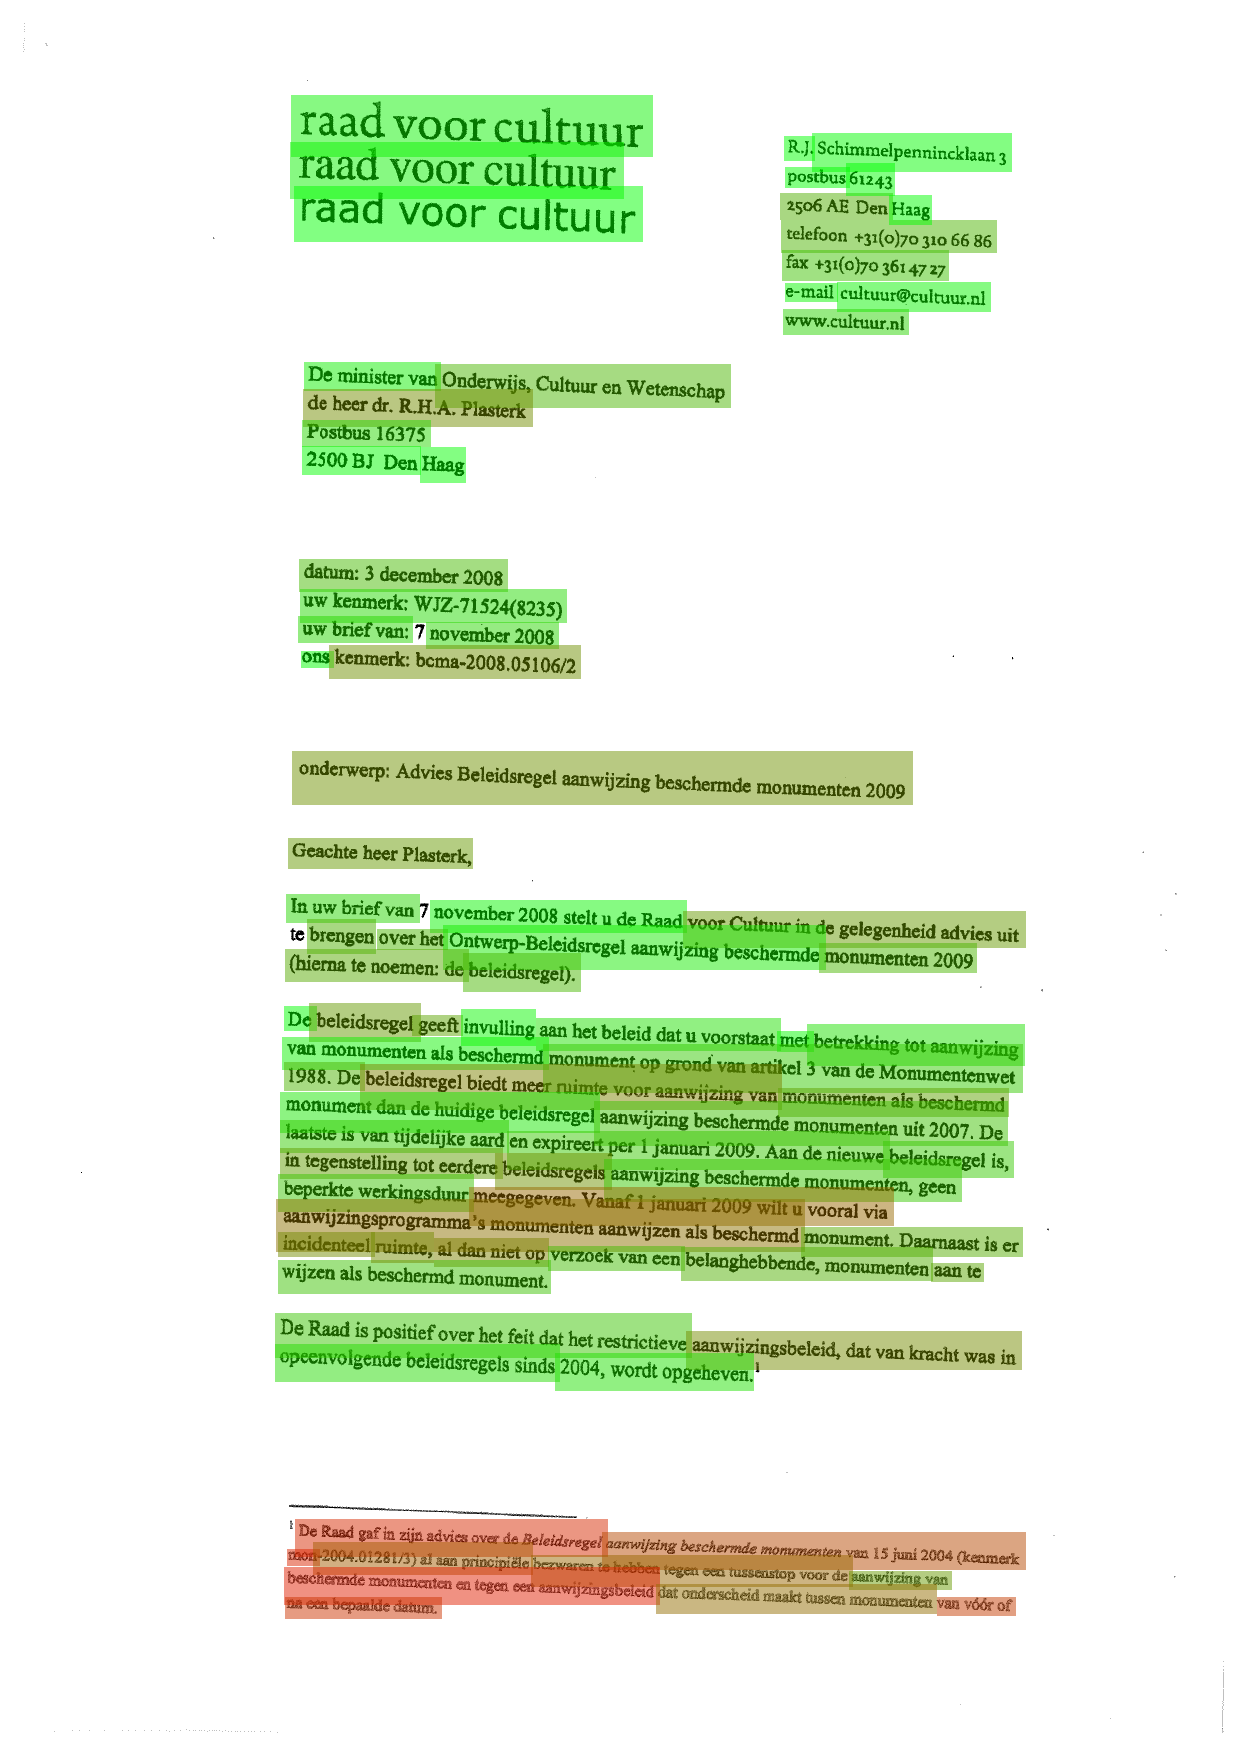

['raad voor cultuur', 'RJ', 'Schimmelpennincklaan 3', 'raad voor cultuur', 'postbus', 'raad voor cultuur', '2506 AE Den', 'telefoon +31(0)70310 66 86', 'fax +31(0)70 3614727', 'e-mail', 'cultuur@cultuurnl', 'www.cultuur,nl', 'De minister van', "'Onderwijs; Cultuur en Wetenschap", 'de beer d. RHA Plasterk', 'Postbus 16375', '2500 BJ Den', 'datum: 3 december 2008', 'uw kenmerk; WJZ-71524(8235)', 'uw brief van;', 'povember 2008', 'ons', 'kenmerk: bcma-2008,05106/2', 'onderwerp: Advies Beleidsregel aanwizing beschermde monumentea 2009', 'Geachte heer Plasterk,', 'In uw brief van', 'novcmber 2008 stelt u de Raad', 'voor Cultuur in de gelegenheid advies uit', 'over bet', 'Ontwerp-Beleidsrcgel aanwijzing beschemde', '(bierna te noemen: de', 'beleidsregel) ', 'monumenten 2009', 'De', "'beleidsregel ,", 'aan het beleid dat u voorstaat', 'van monumenten als bescherd', 'met', 'betrekking tot aanwijzing', '1988. De', 'monument op grond van artikel 3 van de Monumentcnweg', 'beleidsrcgel biedt mcer 

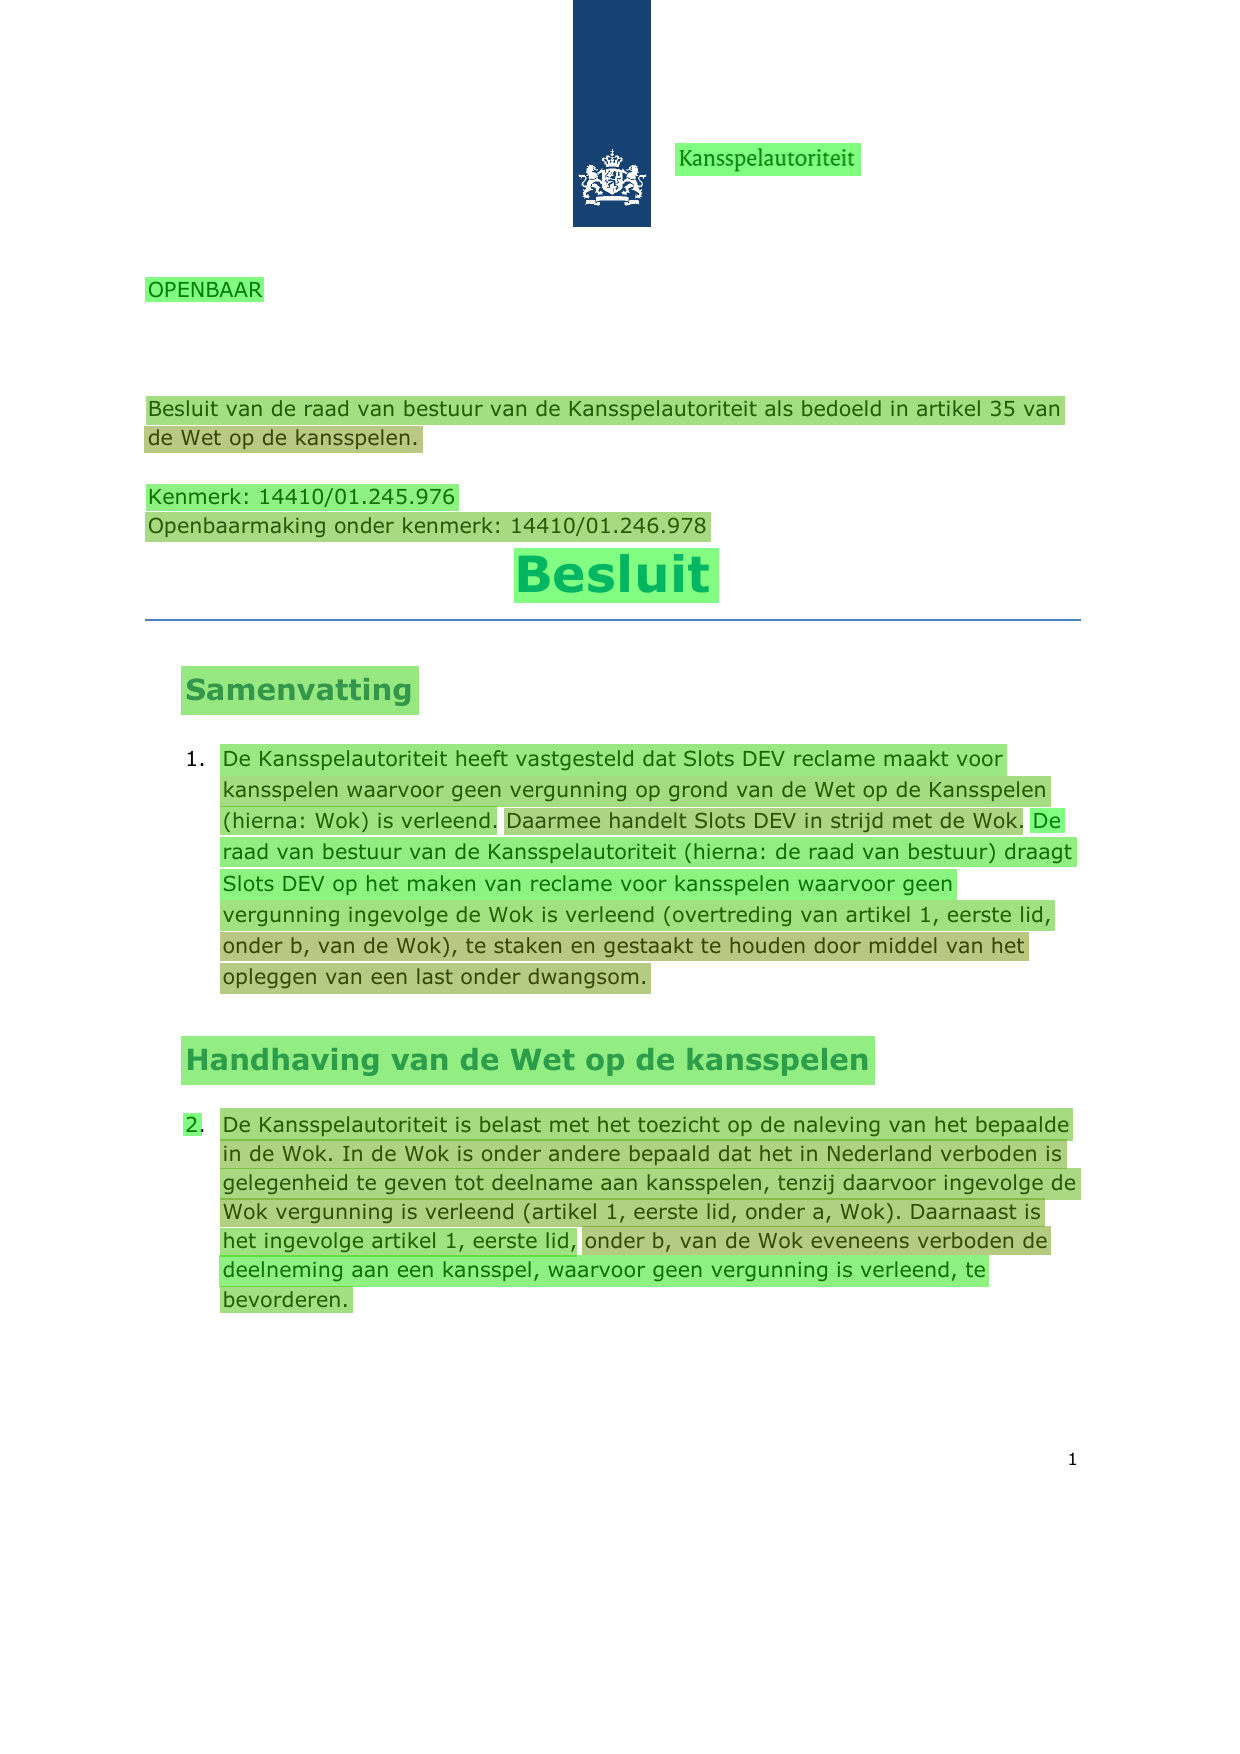

['Kansspelautoriteit', 'OPENBAAR', 'Besluit van de raad van bestuur van de Kansspelautoriteit als bedoeld in artikel 35 van', 'de Wet op de kansspelen.', 'Kenmerk: 14410/01.245.976', 'Openbaarmaking onder kenmerk: 14410/01.246.978', 'Besluit', 'Samenvatting', 'De Kansspelautoriteit heeft vastgesteld dat Slots DEV reclame maakt voor', 'kansspelen waarvoor geen vergunning op grond van de Wet op de Kansspelen', '(hierna: Wok) is verleend-', 'Daarmee handelt Slots DEV in strijd met de Wok', 'De', 'raad van bestuur van de Kansspelautoriteit (hierna: de raad van bestuur) draagt', 'Slots DEV op het maken van reclame voor kansspelen waarvoor geen', 'vergunning ingevolge de Wok is verleend (overtreding van artikel 1, eerste lid,', 'onder b, van de Wok) , te staken en gestaakt te houden door middel van het', 'opleggen van een last onder dwangsom.', 'Handhaving van de Wet op de kansspelen', '2', 'De Kansspelautoriteit is belast met het toezicht op de naleving van het bepaalde', 'in de Wok. In de 

In [9]:
import wetsuite.helpers.shellcolor as sc

test_urls = [
    'https://repository.overheid.nl/frbr/officielepublicaties/kst/31700-VIII/kst-31700-VIII-77-b1/1/pdf/kst-31700-VIII-77-b1.pdf', # non-straight image of text of not the best quality, that OCR makes a bunch of mistakes on

    'https://kansspelautoriteit.nl/publish/library/32/last_onder_dwangsom_slots_dev.pdf', # 1 page of text, the rest is images-of-text
    #'https://kansspelautoriteit.nl/publish/pages/5492/00_082_720_openbare_versie_last_onder_bestuursdwang.pdf', # 5 pages of images-of-text
    #'https://kansspelautoriteit.nl/publish/pages/5491/sanctiebesluit_wedwinkel.pdf', # 25 pages of images-of-text

    #'https://zoek.officielebekendmakingen.nl/trb-2022-72.pdf',
    #'https://zoek.officielebekendmakingen.nl/stb-2022-1.pdf',
    #'https://zoek.officielebekendmakingen.nl/stb-2000-5.pdf',
    #'https://zoek.officielebekendmakingen.nl/gmb-2022-385341.pdf',
    #'https://zoek.officielebekendmakingen.nl/stcrt-2019-42172.pdf',
    #'https://zoek.officielebekendmakingen.nl/prb-2022-10190.pdf',
    #'https://zoek.officielebekendmakingen.nl/wsb-2022-9718.pdf',
]

for url in test_urls:
    print( "== %s =="%wetsuite.helpers.format.url_basename( url ) )
    #print("  FETCH")
    pdfbytes = wetsuite.helpers.net.download(url)

    #page_text = list( wetsuite.pdf.page_text( data ) )

    page_images = list( wetsuite.datacollect.pdf.pages_as_images(pdfbytes) )

    for page_i, page_image in enumerate(page_images):
        #page_image.save('page_%03d.png'%(page_i+1))

        page_ocr_results = wetsuite.extras.ocr.easyocr( page_image )
        for bbox, text, cert in page_ocr_results:
            print( sc.redgreen(text, cert) )

        eval_image = wetsuite.extras.ocr.easyocr_draw_eval( page_image, page_ocr_results )
        #eval_image.save('page_%03d-boxes.png'%(page_i+1))
        display( eval_image )

        ocr_text = wetsuite.extras.ocr.easyocr_text( page_ocr_results )
        print( ocr_text )
        break # do first page of each
